# 心血管疾病数据探索分析


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import rcParams
import warnings
warnings.filterwarnings('ignore')

### 初步数据分析


In [38]:
#本次挑战将优先选择 Seaborn 用于绘图，下面我们定义 Seaborn 全局绘图参数，保证后续图像更加整洁美观。

sns.set()

sns.set_context(
    "notebook",
    font_scale=1.5,
    rc={
        "figure.figsize": (7, 5),
        "axes.titlesize": 14
    }
)

rcParams['figure.figsize'] = 7, 5

In [6]:
df = pd.read_csv(
    'https://labfile.oss.aliyuncs.com/courses/1283/mlbootcamp5_train.csv', sep=';')
print('Dataset size: ', df.shape)
df.head()

Dataset size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


<img src="./4Seaborn_3.png" width='70%'/>

所以数据均为医学检查时收集，主要包含 3 种类别的特征：

- Objective Feature: 基础事实数据。
- Examination Feature: 体检结果。
- Subjective Feature: 患者给出的主观信息。

接下来，我们探索数据值分布情况。这里使用 catplot() 绘制出变量特征的计数条形图。

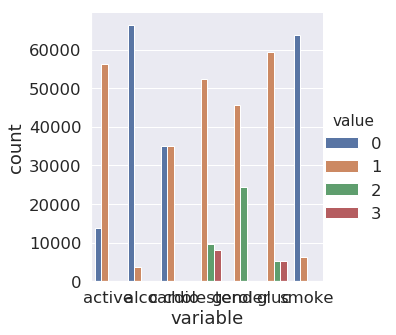

In [33]:
df_uniques = pd.melt(frame=df, value_vars=['gender', 'cholesterol',
                                           'gluc', 'smoke', 'alco',
                                           'active', 'cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable',
                                              'value'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.catplot(x='variable', y='count', hue='value',
            data=df_uniques, kind='bar', height=5)

接下来，让我们按目标值分割数据集，这样往往可以通过绘图结果快速找出相对重要的特征。



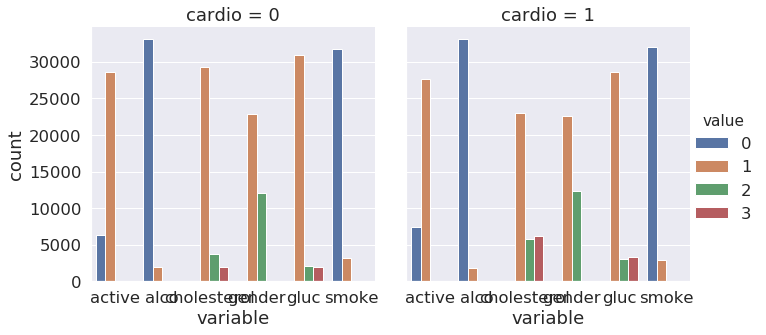

In [35]:
df_uniques = pd.melt(frame=df, value_vars=['gender', 'cholesterol',
                                           'gluc', 'smoke', 'alco',
                                           'active'], id_vars=['cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 'value',
                                              'cardio'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.catplot(x='variable', y='count', hue='value',
            col='cardio', data=df_uniques, kind='bar', height=5)

您可以看到胆固醇和葡萄糖水平对目标变量影响明显较大。这是巧合吗？



### 进一步观察


**问题：数据集中有多少男性和女性？由于 gender 特征没有说明男女，你需要通过分析身高计算得出。**

- [ A ] 45530 女性 和 24470 男性 <
- [ B ] 45530 男性 和 24470 女性
- [ C ] 45470 女性 和 24530 男性
- [ D ] 45470 男性 和 24530 女性

In [45]:
df.pivot_table(index='gender', values='height', aggfunc=np.mean)

df.groupby('gender')['height'].describe(percentiles=[])


#sns.boxplot(x='gender', y='height', data=df)

,count,mean,std,min,50%,max
gender,,,,,,
1,45530.0,161.355612,7.052726,55.0,161.0,250.0
2,24470.0,169.947895,7.228895,65.0,170.0,207.0


**问题：数据集中男性和女性，哪个群体饮酒的频次更高？**

- [ A ] 女性
- [ B ] 男性 <

In [43]:
pd.crosstab(df['alco'], df['gender'])

gender,1,2
alco,,
0,44369,21867
1,1161,2603


** 问题：数据集中男性和女性吸烟者所占百分比的差值是多少？**

- [ A ] 4
- [ B ] 16
- [ C ] 20 <
- [ D ] 24

In [56]:
male = df[df['gender']==2]
male_smoke = male[male['smoke']==1].shape[0]
male_smoke_rate = male_smoke/male.shape[0]

female = df[df['gender']==1]
female_smoke = female[female['smoke']==1].shape[0]
female_smoke_rate = female_smoke/female.shape[0]

male_smoke_rate - female_smoke_rate

0.20102390309976736

In [116]:
df.groupby(['gender'])['smoke'].agg([np.mean])

,mean
gender,
1,0.017856
2,0.218880


**问题：数据集中吸烟者和非吸烟者的年龄中位数之间的差值（以月计）近似是多少？你需要尝试确定出数据集中 age 合理的表示单位。**

- [ A ] 5
- [ B ] 10
- [ C ] 15
- [ D ] 20 <

本次挑战规定 1 年为 365.25 天。

In [68]:
df['age_month'] = df['age']/365.25*12
df.head()
df.groupby('smoke')['age_month'].describe(percentiles=[])

,count,mean,std,min,50%,max
smoke,,,,,,
0,63831.0,640.834521,80.873729,354.759754,647.950719,779.071869
1,6169.0,627.214355,81.939130,469.552361,628.336756,778.217659


### 风险量表图

欧洲心脏病学会的网站上给出了  SCORE scale 量表。它可以用于计算未来 10 年心血管疾病死亡的风险。

<img src="./score.png" width='50%'/>

让我们来看看最右上角的矩形，也就是 60 到 65 岁的吸烟男性的子集。其中，矩形的左下角看到一个值 9，在右上角看到 47。量表意味着对于收缩压（纵坐标）低于 120 （正常血压）的性别年龄组的人来说，心血管疾病的风险估计比收缩压为 [160, 180)[160,180) 的患者（高血压）低 5 倍（47/9）。

接下来，让我们结合量表，并利用挑战数据集进行计算。这里需要注意的是，量表中胆固醇（Cholesterol）水平和挑战数据单位不太一样，我们使用对应关系为：4 mmol/l → 1, 5-7 mmol/l → 2, 8 mmol/l → 3。

** 问题：计算 [60, 65) 年龄区间下，较健康人群（胆固醇类别 1，收缩压低于 120）与高风险人群（胆固醇类别为 3，收缩压 [160, 180)各自心血管病患所占比例。并最终求得二者比例的近似倍数。**

- [ A ] 1
- [ B ] 2
- [ C ] 3
- [ D ] 4

In [89]:
smoking_old_men = df[(df['gender'] == 2) & (df['age_years'] >= 60) & (df['age_years'] < 65) & (df['smoke'] == 1)]

# 胆固醇类别为 1，收缩压低于 120，心血管疾病患者的比例为 26%。
rate1 = smoking_old_men[(smoking_old_men['cholesterol'] == 1) & (smoking_old_men['ap_hi'] < 120)]['cardio'].mean()

# 胆固醇类别为 3，收缩压 [160, 180)[160,180)，心血管疾病患者的比例为 86%。
rate2 = smoking_old_men[(smoking_old_men['cholesterol'] == 3) & (smoking_old_men['ap_hi'] >= 160) & (smoking_old_men['ap_hi'] < 180)]['cardio'].mean()

rate2/rate1

3.342857142857143

所以，挑战数据给出的比例大约是 $\frac{0.86}{0.26} \approx 3$ 倍，而量表给出的是 5 倍。当然，这依赖与给定年龄组中的病人比例。

### BMI 指数分析

挑战将需要创建一个新的特征 BMI，BMI 为身高体重指数，其可以反映体重的标准情况，计算公式为：

$$BMI = \frac{weight (kg)}{height^2 (m)}$$

 
正常 BMI 指数一般在 18.5 到 25 之间。

** 问题：请选择下面叙述正确的有：**

- [ A ] 数据集样本中 BMI 中位数在正常范围内。
- [ B ] 女性的平均 BMI 指数高于男性。 <
- [ C ] 健康人群的 BMI 平均高于患病人群。
- [ D ] 健康和不饮酒男性中，BMI 比健康不饮酒女性更接近正常值。<

In [117]:
df['BMI'] = df['weight']/((df['height']/100)**2)
df.pivot_table(index='gender', values='BMI', aggfunc=np.mean)
df.pivot_table(index='cardio', values='BMI', aggfunc=np.mean)
df[ (df['cardio']==0)&(df['alco']==0)&(df['gender']==2) ]['BMI'].mean()
#df[ (df['cardio']==0)&(df['alco']==0)&(df['gender']==1) ]['BMI'].mean()
df.groupby(['gender', 'alco', 'cardio'])['BMI'].median().to_frame()



BMI
gender alco cardio           
1      0    0       25.654372
            1       27.885187
       1    0       27.885187
            1       30.110991
2      0    0       25.102391
            1       26.674874
       1    0       25.351541
            1       27.530797

### 数据清洗

你可能会注意到给出的数据并不够完美，在进一步可视化之前，我们需要对数据进行清洗。

**问题：请按照以下列举的项目，过滤掉数据中统计有误的部分：**

- 血压特征中，舒张压高于收缩压的样本。
- 身高特征中，低于 2.5％ 分位数的样本。
- 身高特征中，高于 97.5％ 分位数的样本。
- 体重特征中，低于 2.5％ 分位数的样本。
- 体重特征中，高于 97.5％ 分位数的样本。

百分位数请使用 pd.Series.quantile 方法进行确定，不熟悉可以阅读  官方文档

 **问题：清洗掉的数据占原数据总量的近似百分比？**

- [ A ] 8%
- [ B ] 9%
- [ C ] 10% <
- [ D ] 11%

In [114]:
df1 = df[ (df['ap_lo'])<=(df['ap_hi']) ]
df2 = df1[ df1['height'] >= df1['height'].quantile(0.025) ]
df3 = df2[ df2['height'] <= df2['height'].quantile(0.975) ]
df4 = df3[ df3['weight'] >= df3['weight'].quantile(0.025) ]
df5 = df4[ df4['weight'] <= df4['weight'].quantile(0.975) ]
(df.shape[0]-df5.shape[0]) / df.shape[0]


0.10308571428571428